In [44]:
import pandas as pd
import numpy as np
import pybaseball as pb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [45]:
df_2023 = pd.read_csv("C:/Users/wampl/sxwOBA/statcast_data/2023.csv")
sample_df = df_2023.sample(n=10000)
sample_df.to_csv('C:/Users/wampl/sxwOBA/statcast_data/sample_2023.csv', index=False)

In [46]:
df1 = pd.read_csv("C:/Users/wampl/sxwOBA/statcast_data/woba_events_2021.csv")
df2 = pd.read_csv("C:/Users/wampl/sxwOBA/statcast_data/woba_events_2022.csv")
df3 = pd.read_csv("C:/Users/wampl/sxwOBA/statcast_data/woba_events_2023.csv")

In [47]:
df1.groupby(['player_name', 'pitcher'], as_index=False)['sxwOBA_adj'].agg(['mean', 'count']).sort_values('count', ascending=False).head(20)

,,mean,count
player_name,pitcher,,
"Wheeler, Zack",554430,0.258952,839
"Alcantara, Sandy",645261,0.297152,833
"Wainwright, Adam",425794,0.299090,821
"Buehler, Walker",621111,0.271766,801
"Castillo, Luis",622491,0.300465,788
"Berríos, José",621244,0.301280,779
"Hendricks, Kyle",543294,0.340939,778
"Gausman, Kevin",592332,0.291373,771
"Ray, Robbie",592662,0.295327,770


In [48]:
df2.groupby(['player_name', 'pitcher'], as_index=False)['sxwOBA_adj'].agg(['mean', 'count']).sort_values('count', ascending=False).head(20)

,,mean,count
player_name,pitcher,,
"Alcantara, Sandy",645261,0.270309,880
"Wainwright, Adam",425794,0.332386,803
"Valdez, Framber",664285,0.291388,801
"Pérez, Martín",527048,0.289988,789
"Mikolas, Miles",571945,0.312121,789
"Burnes, Corbin",669203,0.277542,786
"Bieber, Shane",669456,0.290363,786
"Manoah, Alek",666201,0.285947,782
"Nola, Aaron",605400,0.267631,781


In [49]:
df2.groupby(['player_name', 'pitcher'], as_index=False)[['estimated_woba_using_speedangle', 'xwOBA_adj']].agg(['mean', 'count']).sort_values(('estimated_woba_using_speedangle', 'count'), ascending=False).round(3).head(20)

KeyError: "Columns not found: 'xwOBA_adj'"

In [ ]:
leaders_23 = df3.groupby(['player_name', 'pitcher'], as_index=False)['xwOBA_adj', 'sxwOBA_adj'].mean()


C:\Users\wampl\AppData\Local\Temp\ipykernel_3736\1807637183.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  leaders_23 = df3.groupby(['player_name', 'pitcher'], as_index=False)['xwOBA_adj', 'sxwOBA_adj'].mean()


In [ ]:
df3.events.value_counts(normalize=True).round(2)

field_out                    0.40
strikeout                    0.23
single                       0.14
walk                         0.08
double                       0.05
home_run                     0.03
force_out                    0.02
grounded_into_double_play    0.02
hit_by_pitch                 0.01
sac_fly                      0.01
field_error                  0.01
triple                       0.00
double_play                  0.00
fielders_choice              0.00
fielders_choice_out          0.00
strikeout_double_play        0.00
sac_fly_double_play          0.00
Name: events, dtype: float64

In [ ]:
df3['xwOBA_adj'].mean()

0.3142880715370057

In [ ]:
def get_mlbam_id(row):
    """
    Attempts to find the mlbam id for a player using their fangraphs id and name
    """
    # First try fuzzy lookup using player first and last name
    result = pb.playerid_lookup(row['last_name'], row['first_name'], fuzzy=True)
    try:
        # If there are multiple results, try to find the one that matches the fangraphs id
        result = result.loc[result['key_fangraphs'] == row['IDfg']].iloc[0]
        return result['key_mlbam']
    except:
        # If no match, try reverse lookup using fangraphs id
        try:
            print('failed to find mlbam id for', row['Name'], row['last_name'], row['first_name'])
            print('trying reverse lookup')
            result = pb.playerid_reverse_lookup([row['IDfg']], key_type='fangraphs').iloc[0]
            return result['key_mlbam']
        except:
        # If no match, try to find the player with the same name that played in the mlb most recently
            result['mlb_played_last'].replace('', np.nan, inplace=True)
            result = result.loc[result['mlb_played_last'] > 2015].iloc[0]
            if len(result) != 0:
                return result['key_mlbam']
            else:
                return 000000

In [ ]:
def get_fg_stats(year, selected_stats):
    import pybaseball as pb
    """
    returns fangraphs batting stats for a given year
    """
    out = pb.fg_pitching_data(year, qual=20)
    out['first_name'] = out['Name'].str.split(n=1).str[0]
    out['last_name'] = out['Name'].str.split(n=1).str[1]
    out['key_mlbam'] = out.apply(get_mlbam_id, axis=1)
    out.dropna(subset=['key_mlbam'], inplace=True)
    return out[selected_stats]


In [ ]:
pitching_23 = get_fg_stats(2023, ['Name', 'IP', 'ERA', 'FIP', 'xFIP', 'SIERA', 'xERA', 'GB%', 'key_mlbam'])

No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
failed to find mlbam id for Carlos Hernandez Hernandez Carlos
trying reverse lookup
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 most similar names.
No identically matched names found! Returning the 5 

In [ ]:
pitching_23.head()

,Name,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam
94,Kevin Gausman,115.2,3.03,2.47,2.93,3.05,3.53,0.430,592332
110,Zac Gallen,123.1,3.14,2.90,3.50,3.62,3.66,0.385,668678
219,Zack Wheeler,111.1,4.04,2.98,3.49,3.48,3.23,0.412,554430
69,Framber Valdez,117.1,2.76,2.91,2.91,3.25,3.90,0.546,664285
169,Spencer Strider,110.2,3.66,2.82,2.79,2.65,3.05,0.326,675911


In [ ]:
df_2023 = pd.merge(leaders_23, pitching_23, left_on='pitcher', right_on='key_mlbam', how='left')
df_2023.head()

,player_name,pitcher,xwOBA_adj,sxwOBA_adj,Name,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam
0,"Abad, Fernando",472551,0.427053,0.530503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Abbott, Andrew",671096,0.286405,0.294729,Andrew Abbott,47.2,2.45,4.35,4.60,4.33,3.58,0.203,671096.0
2,"Abbott, Cory",676265,0.317033,0.323518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Abreu, Albert",656061,0.305239,0.325440,Albert Abreu,41.1,4.14,4.70,4.37,4.06,4.18,0.464,656061.0
4,"Abreu, Bryan",650556,0.279196,0.286540,Bryan Abreu,45.1,2.78,3.45,3.05,2.79,3.31,0.374,650556.0


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
runs_per_nine_2023 = 4.31


df_2023['xERA_adj'] = round(runs_per_nine_2023 * ((df_2023['xwOBA_adj'] / df3['xwOBA_adj'].mean())**2), 2)
df_2023['sxERA_adj'] = round(runs_per_nine_2023 * ((df_2023['sxwOBA_adj'] / df3['sxwOBA_adj'].mean())**2), 2)

In [ ]:
df_2023 = df_2023.dropna()

In [ ]:
df_2023.sort_values('IP', ascending=False).head(50).round(2)

,player_name,pitcher,xwOBA_adj,sxwOBA_adj,Name,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam,xERA_adj,sxERA_adj
721,"Webb, Logan",657277,0.28,0.29,Logan Webb,133.0,3.11,3.33,2.91,3.11,3.58,0.60,657277.0,3.52,3.47
496,"Nola, Aaron",605400,0.29,0.30,Aaron Nola,126.1,4.27,4.20,3.82,3.85,3.74,0.41,605400.0,3.73,3.63
191,"Eovaldi, Nathan",543135,0.28,0.29,Nathan Eovaldi,123.2,2.69,3.27,3.79,3.98,3.41,0.52,543135.0,3.47,3.51
226,"Gallen, Zac",668678,0.29,0.29,Zac Gallen,123.1,3.14,2.90,3.50,3.62,3.66,0.38,668678.0,3.73,3.53
137,"Cole, Gerrit",543037,0.29,0.29,Gerrit Cole,123.0,2.78,3.39,3.76,3.75,3.74,0.38,543037.0,3.64,3.55
341,"Keller, Mitch",656605,0.29,0.30,Mitch Keller,123.0,3.73,3.61,3.73,3.84,3.38,0.45,656605.0,3.63,3.79
453,"Mikolas, Miles",571945,0.33,0.33,Miles Mikolas,121.2,4.14,3.95,4.65,4.76,4.96,0.39,571945.0,4.88,4.42
14,"Alcantara, Sandy",645261,0.31,0.32,Sandy Alcantara,120.1,4.64,4.00,4.07,4.31,4.39,0.50,645261.0,4.32,4.14
651,"Stroman, Marcus",573186,0.30,0.30,Marcus Stroman,118.2,2.88,3.39,3.71,4.09,3.71,0.58,573186.0,3.85,3.69
689,"Valdez, Framber",664285,0.30,0.31,Framber Valdez,117.1,2.76,2.91,2.91,3.25,3.90,0.55,664285.0,3.96,3.97


In [ ]:
df_2023.sort_values('sxERA', ascending=True).head(50)

,player_name,pitcher,xwOBA_adj,sxwOBA_adj,Name,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam,sxERA
609,"Sewald, Paul",623149,0.200757,0.213251,Paul Sewald,37.2,3.11,2.71,3.00,2.51,1.69,0.304,623149.0,1.06
766,"deGrom, Jacob",594798,0.204070,0.218777,Jacob deGrom,30.1,2.67,1.58,2.32,2.22,1.85,0.379,594798.0,1.16
46,"Bautista, Félix",642585,0.207615,0.213987,Felix Bautista,44.0,1.02,1.59,1.70,1.74,1.85,0.381,642585.0,1.26
265,"Hader, Josh",623352,0.212073,0.209321,Josh Hader,35.0,1.03,2.41,3.42,3.17,1.99,0.418,623352.0,1.39
122,"Chapman, Aroldis",547973,0.212857,0.223190,Aroldis Chapman,35.1,2.04,1.43,2.25,2.64,1.95,0.508,547973.0,1.42
27,"Armstrong, Shawn",542888,0.219714,0.234196,Shawn Armstrong,20.2,0.87,2.52,3.53,3.24,2.20,0.426,542888.0,1.61
577,"Rogers, Tyler",643511,0.219763,0.233723,Tyler Rogers,49.0,2.20,3.46,4.34,4.15,2.09,0.493,643511.0,1.62
50,"Bednar, David",670280,0.226360,0.217736,David Bednar,37.0,1.22,1.78,3.44,2.83,2.13,0.366,670280.0,1.81
602,"Scott, Tanner",656945,0.233114,0.241457,Tanner Scott,46.0,2.74,2.17,2.55,2.59,2.39,0.489,656945.0,2.00
218,"Fried, Max",608331,0.233933,0.252621,Max Fried,26.0,2.08,3.07,3.18,3.46,2.37,0.609,608331.0,2.03


In [ ]:
df_2023['diff'] = df_2023['xERA'].sub(df_2023['sxERA'])

In [ ]:
df_2023.corr()

C:\Users\wampl\AppData\Local\Temp\ipykernel_9640\4051704210.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,pitcher,xwOBA_adj,sxwOBA_adj,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam,sxERA,diff
pitcher,1.000000,0.015047,0.026884,-0.088847,0.032831,0.017176,0.023368,0.014750,0.006024,0.003726,1.000000,0.014976,-0.033589
xwOBA_adj,0.015047,1.000000,0.955758,0.056113,0.695448,0.796259,0.689673,0.743327,0.971694,-0.172415,0.015047,0.999996,0.143684
sxwOBA_adj,0.026884,0.955758,1.000000,0.003579,0.716701,0.799788,0.667549,0.715513,0.937102,-0.111078,0.026884,0.955779,0.172422
IP,-0.088847,0.056113,0.003579,1.000000,-0.065054,-0.037001,-0.087888,0.070458,0.020091,-0.025679,-0.088847,0.056173,-0.136477
ERA,0.032831,0.695448,0.716701,-0.065054,1.000000,0.689703,0.535857,0.544545,0.700436,-0.178336,0.032831,0.695476,0.203205
FIP,0.017176,0.796259,0.799788,-0.037001,0.689703,1.000000,0.788980,0.761411,0.791694,-0.233178,0.017176,0.796292,0.189595
xFIP,0.023368,0.689673,0.667549,-0.087888,0.535857,0.788980,1.000000,0.933732,0.674683,-0.382389,0.023368,0.689744,0.117802
SIERA,0.014750,0.743327,0.715513,0.070458,0.544545,0.761411,0.933732,1.000000,0.734955,-0.213785,0.014750,0.743382,0.159667
xERA,0.006024,0.971694,0.937102,0.020091,0.700436,0.791694,0.674683,0.734955,1.000000,-0.143648,0.006024,0.971718,0.373396
GB%,0.003726,-0.172415,-0.111078,-0.025679,-0.178336,-0.233178,-0.382389,-0.213785,-0.143648,1.000000,0.003726,-0.172308,0.074912


In [ ]:
df3.groupby(['player_name'], as_index=False)['sxwOBA', 'sxwOBA_adj', 'launch_speed', 'launch_angle', 'gidp_prob'].agg(['mean', 'count', 'sum']).sort_values(('gidp_prob', 'sum'), ascending=False).head(20)

C:\Users\wampl\AppData\Local\Temp\ipykernel_9640\1416161095.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



sxwOBA                   sxwOBA_adj                    \
                      mean count         sum       mean count         sum   
player_name                                                                 
Webb, Logan       0.297078   532  158.045413   0.289879   532  154.215635   
Alcantara, Sandy  0.323532   529  171.148551   0.316573   529  167.467172   
Stroman, Marcus   0.305994   495  151.467259   0.298886   495  147.948616   
Corbin, Patrick   0.382062   507  193.705628   0.375153   507  190.202645   
Eovaldi, Nathan   0.298613   475  141.841331   0.291371   475  138.401136   
Gibson, Kyle      0.330192   514  169.718727   0.323507   514  166.282522   
Mikolas, Miles    0.333015   542  180.494198   0.326807   542  177.129582   
Cobb, Alex        0.335462   430  144.248458   0.327677   430  140.901011   
Valdez, Framber   0.316460   489  154.749055   0.309854   489  151.518436   
Bieber, Shane     0.347153   485  168.369258   0.340530   485  165.157108   
Keller, Mitch     0.308771   514  158.708502   0.302671   514  155.572853   
Bassitt, Chris    0.337199   509  171.634468   0.331179   509  168.569868   
Kirby, George     0.314983   472  148.671836   0.308511   472  145.617149   
Elder, Bryce      0.320421   451  144.509902   0.313650   451  141.456185   
Ashcraft, Graham  0.361416   415  149.987783   0.354093   415  146.948663   
Oviedo, Johan     0.336531   490  164.900101   0.330379   490  161.885703   
Nelson, Ryne      0.339691   450  152.861105   0.333032   450  149.864501   
Berríos, José     0.325898   487  158.712169   0.319773   487  155.729306   
Singer, Brady     0.358111   476  170.460824   0.351854   476  167.482606   
Gomber, Austin    0.380245   439  166.927643   0.373473   439  163.954842   

                 launch_speed                launch_angle                \
                         mean count      sum         mean count     sum   
player_name                                                               
Webb, Logan         90.452575   369  33377.0     2.872973   370  1063.0   
Alcantara, Sandy    89.010444   383  34091.0     7.553525   383  2893.0   
Stroman, Marcus     90.026023   342  30788.9     2.935860   343  1007.0   
Corbin, Patrick     90.429668   391  35358.0     9.774936   391  3822.0   
Eovaldi, Nathan     87.996341   328  28862.8     5.307927   328  1741.0   
Gibson, Kyle        89.257796   372  33203.9     8.903226   372  3312.0   
Mikolas, Miles      89.711294   425  38127.3    14.164706   425  6020.0   
Cobb, Alex          89.404531   309  27626.0     1.411003   309   436.0   
Valdez, Framber     91.639752   322  29508.0     3.596273   322  1158.0   
Bieber, Shane       91.258989   356  32488.2     9.528090   356  3392.0   
Keller, Mitch       86.493842   341  29494.4     9.222874   341  3145.0   
Bassitt, Chris      87.665242   351  30770.5    12.504274   351  4389.0   
Kirby, George       88.669577   355  31477.7    12.602817   355  4474.0   
Elder, Bryce        89.626380   326  29218.2     7.122699   326  2322.0   
Ashcraft, Graham    88.593092   304  26932.3     7.144737   304  2172.0   
Oviedo, Johan       88.767857   336  29826.0     9.845238   336  3308.0   
Nelson, Ryne        91.103170   347  31612.8    14.671470   347  5091.0   
Berríos, José       87.632931   331  29006.5     9.909366   331  3280.0   
Singer, Brady       91.449565   345  31550.1     9.872464   345  3406.0   
Gomber, Austin      90.105588   340  30635.9    11.392962   341  3885.0   

                 gidp_prob                   
                      mean count        sum  
player_name                                  
Webb, Logan       0.032428   369  11.965757  
Alcantara, Sandy  0.030032   383  11.502100  
Stroman, Marcus   0.032239   341  10.993648  
Corbin, Patrick   0.027992   391  10.944719  
Eovaldi, Nathan   0.032971   326  10.748545  
Gibson, Kyle      0.028938   371  10.736078  
Mikolas, Miles    0.024735   425  10.512405  
Cobb, Alex        0.033847   309  10.458763  
Valdez, Framber 

In [ ]:
def get_sum_gidp_probs(df, player_name):
    return df.loc[df['player_name']==player_name, 'gidp_prob'].sum().round()

In [ ]:
get_sum_gidp_probs(df3, 'Webb, Logan')

14.0

In [ ]:
get_sum_gidp_probs(df3, 'Stroman, Marcus')

13.0

In [ ]:
get_sum_gidp_probs(df3, 'Elder, Bryce')

12.0

In [ ]:
get_sum_gidp_probs(df3, 'Cobb, Alex')

11.0

In [35]:
import plotly.express as px

px.scatter(df_2023.loc[df_2023['IP']>20], x='xERA_adj', y='sxERA_adj', color='GB%', hover_name='Name', hover_data=['ERA', 'xERA'], trendline='ols')

In [37]:
px.scatter(df_2023.loc[df_2023['IP']>50], x='xERA', y='xERA_adj', color='GB%', hover_name='Name', hover_data=['ERA', 'xERA'], trendline='ols')

In [41]:
df3.loc[(df3['player_name']=='Cobb, Alex') & (df3['events']=='grounded_into_double_play'), ['rf_xwoba', 'sxwOBA', 'gidp_prob', 'gidp_adj', 'sxwOBA_adj', 'xwOBA_adj', 'estimated_woba_using_speedangle']].head(20).round(3)

,rf_xwoba,sxwOBA,gidp_prob,gidp_adj,sxwOBA_adj,xwOBA_adj,estimated_woba_using_speedangle
22522,0.112,0.163,0.036,0.011,0.152,0.123,0.134
34270,0.178,0.153,0.028,0.009,0.144,0.123,0.132
34278,0.104,0.053,0.039,0.013,0.040,0.051,0.064
40530,0.038,0.045,0.051,0.016,0.029,0.095,0.111
46215,0.138,0.056,0.059,0.019,0.037,0.060,0.079
46235,0.110,0.062,0.059,0.019,0.044,0.050,0.069
50834,0.580,0.622,0.025,0.008,0.613,0.512,0.520
56470,0.126,0.206,0.036,0.011,0.195,0.223,0.234
62787,0.214,0.248,0.037,0.012,0.236,0.253,0.265
80330,0.317,0.265,0.033,0.011,0.255,0.233,0.244


In [43]:
df3.loc[:, ['rf_xwoba', 'sxwOBA', 'gidp_prob', 'gidp_adj', 'sxwOBA_adj', 'xwOBA_adj', 'estimated_woba_using_speedangle']].mean()

rf_xwoba                           0.327016
sxwOBA                             0.328655
gidp_prob                          0.026741
gidp_adj                           0.005761
sxwOBA_adj                         0.322879
xwOBA_adj                          0.314288
estimated_woba_using_speedangle    0.320061
dtype: float64

In [42]:
df3.loc[df3['player_name']=='Cobb, Alex', ['rf_xwoba', 'sxwOBA', 'gidp_prob', 'gidp_adj', 'sxwOBA_adj', 'xwOBA_adj', 'estimated_woba_using_speedangle']].mean()

rf_xwoba                           0.338642
sxwOBA                             0.335462
gidp_prob                          0.033847
gidp_adj                           0.007785
sxwOBA_adj                         0.327677
xwOBA_adj                          0.318997
estimated_woba_using_speedangle    0.326781
dtype: float64

In [57]:
df_2023.loc[df_2023['IP']>50].sort_values('sxERA', ascending=True).reset_index().sort_values('diff', ascending=False).head(20)

,index,player_name,pitcher,xwOBA_adj,sxwOBA_adj,Name,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam,sxERA,diff
155,480,"Muller, Kyle",666205,0.411799,0.422179,Kyle Muller,52.0,7.79,6.11,5.31,5.46,8.15,0.478,666205.0,7.19,0.96
156,707,"Wainwright, Adam",425794,0.413839,0.419604,Adam Wainwright,51.2,7.66,5.89,5.87,5.81,8.20,0.351,425794.0,7.25,0.95
154,507,"Ortiz, Luis L.",682847,0.403541,0.408546,Luis Ortiz,53.2,4.86,6.20,5.34,5.54,7.75,0.478,682847.0,6.95,0.80
145,248,"Gomber, Austin",596295,0.361718,0.373473,Austin Gomber,96.0,6.19,5.83,4.90,5.11,6.26,0.425,596295.0,5.73,0.53
142,569,"Rodriguez, Grayson",680570,0.357139,0.374097,Grayson Rodriguez,50.1,7.33,5.64,3.88,4.17,6.11,0.413,680570.0,5.60,0.51
116,22,"Anderson, Chase",502624,0.337657,0.369952,Chase Anderson,54.2,6.26,6.61,5.40,5.18,5.51,0.367,502624.0,5.04,0.47
118,618,"Singer, Brady",663903,0.338539,0.351854,Brady Singer,102.2,5.70,4.41,4.49,4.69,5.47,0.474,663903.0,5.06,0.41
148,141,"Corbin, Patrick",571578,0.366278,0.375153,Patrick Corbin,114.0,4.89,4.89,4.49,4.85,6.26,0.447,571578.0,5.87,0.39
151,125,"Chirinos, Yonny",630023,0.369701,0.364895,Yonny Chirinos,62.2,4.02,5.53,5.38,5.34,6.35,0.432,630023.0,5.97,0.38
94,447,"Medina, Luis",665622,0.323310,0.341008,Luis Medina,65.1,5.79,5.09,4.48,4.63,4.99,0.464,665622.0,4.62,0.37


In [30]:
df3.groupby('pitcher_team')['sxwOBA', 'sxwOBA_adj'].mean()

C:\Users\wampl\AppData\Local\Temp\ipykernel_5028\2241078727.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,sxwOBA,sxwOBA_adj
pitcher_team,,
ATL,0.319938,0.313964
AZ,0.332770,0.326732
BAL,0.331177,0.325446
BOS,0.324159,0.317724
CHC,0.324020,0.317540
CIN,0.338791,0.333138
CLE,0.326881,0.320497
COL,0.351858,0.345476
CWS,0.333722,0.328482


In [69]:
df3.groupby('pitch_type')['sxwOBA', 'sxwOBA_adj'].mean()

C:\Users\wampl\AppData\Local\Temp\ipykernel_6328\3978275196.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,sxwOBA,sxwOBA_adj
pitch_type,,
CH,0.303523,0.296302
CS,0.214801,0.207791
CU,0.288611,0.282795
EP,0.503337,0.498183
FA,0.455601,0.450300
FC,0.351998,0.345580
FF,0.359435,0.354720
FO,0.199135,0.195612
FS,0.260962,0.254158


<AxesSubplot: xlabel='launch_angle', ylabel='is_gidp'>

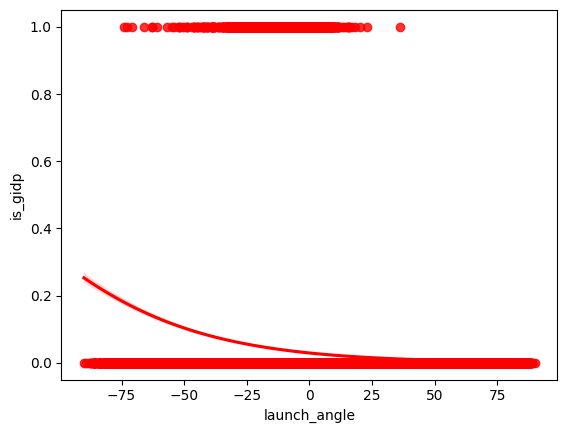

In [79]:
df3['is_gidp'] = df3['events'].isin(['grounded_into_double_play'])
sns.regplot(data=df3, x='launch_angle', y='is_gidp', color='red', logistic=True)

In [46]:
df_2023['xERA'].describe()

count    20.000000
mean      4.110500
std       0.763093
min       3.090000
25%       3.567500
50%       3.920000
75%       4.550000
max       6.260000
Name: xERA, dtype: float64

In [47]:
df_2023['sxERA'].describe()

count    20.000000
mean      3.948000
std       0.497368
min       3.200000
25%       3.582500
50%       3.945000
75%       4.277500
max       5.170000
Name: sxERA, dtype: float64

In [55]:
df_2023.corr()

C:\Users\wampl\AppData\Local\Temp\ipykernel_9640\4051704210.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,pitcher,xwOBA_adj,sxwOBA_adj,IP,ERA,FIP,xFIP,SIERA,xERA,GB%,key_mlbam,sxERA,diff
pitcher,1.000000,0.015047,0.026884,-0.088847,0.032831,0.017176,0.023368,0.014750,0.006024,0.003726,1.000000,0.014976,-0.033589
xwOBA_adj,0.015047,1.000000,0.955758,0.056113,0.695448,0.796259,0.689673,0.743327,0.971694,-0.172415,0.015047,0.999996,0.143684
sxwOBA_adj,0.026884,0.955758,1.000000,0.003579,0.716701,0.799788,0.667549,0.715513,0.937102,-0.111078,0.026884,0.955779,0.172422
IP,-0.088847,0.056113,0.003579,1.000000,-0.065054,-0.037001,-0.087888,0.070458,0.020091,-0.025679,-0.088847,0.056173,-0.136477
ERA,0.032831,0.695448,0.716701,-0.065054,1.000000,0.689703,0.535857,0.544545,0.700436,-0.178336,0.032831,0.695476,0.203205
FIP,0.017176,0.796259,0.799788,-0.037001,0.689703,1.000000,0.788980,0.761411,0.791694,-0.233178,0.017176,0.796292,0.189595
xFIP,0.023368,0.689673,0.667549,-0.087888,0.535857,0.788980,1.000000,0.933732,0.674683,-0.382389,0.023368,0.689744,0.117802
SIERA,0.014750,0.743327,0.715513,0.070458,0.544545,0.761411,0.933732,1.000000,0.734955,-0.213785,0.014750,0.743382,0.159667
xERA,0.006024,0.971694,0.937102,0.020091,0.700436,0.791694,0.674683,0.734955,1.000000,-0.143648,0.006024,0.971718,0.373396
GB%,0.003726,-0.172415,-0.111078,-0.025679,-0.178336,-0.233178,-0.382389,-0.213785,-0.143648,1.000000,0.003726,-0.172308,0.074912


In [3]:
current.loc[current['target'] == 7].head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,of_fielding_alignment,batter_team,pitcher_team,stand_L,stand_R,batter_name,rf_xwoba,sxwOBA,sxwoba_prob_model,pulled_barrel
33,33,SL,2023-06-26,91.3,-1.90,5.95,"Baumann, Mike",663886,657508,strikeout,...,0.0,CIN,BAL,0,1,tyler stephenson,0.0,0.0,NaN,0
80,80,CH,2023-06-26,83.9,-0.46,6.71,"Baker, Bryan",680574,641329,strikeout,...,0.0,CIN,BAL,0,1,matt mclain,0.0,0.0,NaN,0
84,84,FF,2023-06-26,97.9,-0.54,6.61,"Baker, Bryan",621028,641329,strikeout,...,0.0,CIN,BAL,0,1,kevin newman,0.0,0.0,NaN,0
177,177,FS,2023-06-26,81.0,-1.45,5.99,"Cruz, Fernando",669720,518585,strikeout,...,0.0,BAL,CIN,0,1,austin hays,0.0,0.0,NaN,0
183,183,FS,2023-06-26,80.8,-1.19,6.09,"Cruz, Fernando",622761,518585,strikeout,...,0.0,BAL,CIN,0,1,jorge mateo,0.0,0.0,NaN,0


In [4]:
df = pd.read_csv("statcast_data/2023.csv")

In [5]:
df.head().reset_index(drop=True)

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,0,FF,2023-06-26,96.6,1.30,5.46,"Pérez, Cionel",663697,672335,field_out,...,10,3,10,3,10,Standard,Standard,143.0,0.000,-0.470
1,1,SL,2023-06-26,84.0,1.13,5.41,"Pérez, Cionel",680574,672335,hit_by_pitch,...,10,3,10,3,10,Strategic,Standard,337.0,0.000,0.268
2,2,FF,2023-06-26,98.1,1.02,5.43,"Pérez, Cionel",680574,672335,NaN,...,10,3,10,3,10,Standard,Standard,135.0,0.000,-0.036
3,3,FF,2023-06-26,97.2,1.12,5.42,"Pérez, Cionel",621028,672335,field_out,...,10,3,10,3,10,Strategic,Standard,146.0,0.001,-0.305
4,4,FF,2023-06-26,98.2,1.17,5.40,"Pérez, Cionel",592200,672335,walk,...,10,3,10,3,10,Standard,Standard,138.0,-0.001,0.227


In [6]:
df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,0,FF,2023-06-26,96.6,1.30,5.46,"Pérez, Cionel",663697,672335,field_out,...,10,3,10,3,10,Standard,Standard,143.0,0.000,-0.470
1,1,SL,2023-06-26,84.0,1.13,5.41,"Pérez, Cionel",680574,672335,hit_by_pitch,...,10,3,10,3,10,Strategic,Standard,337.0,0.000,0.268
2,2,FF,2023-06-26,98.1,1.02,5.43,"Pérez, Cionel",680574,672335,NaN,...,10,3,10,3,10,Standard,Standard,135.0,0.000,-0.036
3,3,FF,2023-06-26,97.2,1.12,5.42,"Pérez, Cionel",621028,672335,field_out,...,10,3,10,3,10,Strategic,Standard,146.0,0.001,-0.305
4,4,FF,2023-06-26,98.2,1.17,5.40,"Pérez, Cionel",592200,672335,walk,...,10,3,10,3,10,Standard,Standard,138.0,-0.001,0.227


In [7]:
sprint_speed = pb.statcast_sprint_speed(2023, min_opp=5)
sprint_speed.head()

,last_name,first_name,player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
0,De La Cruz,Elly,682829,113,CIN,3B,21,49,30.0,4.15,30.8
1,Witt Jr.,Bobby,677951,118,KC,SS,23,121,66.0,4.15,30.4
2,Thompson,Bubba,669352,140,TEX,LF,25,24,19.0,4.22,30.4
3,Turner,Trea,607208,143,PHI,SS,30,117,49.0,4.13,30.3
4,Carroll,Corbin,682998,109,AZ,LF,22,131,58.0,4.08,30.1


In [4]:
import pandas as pd
import os

# read in the dataframes
base_dir = "C:/Users/wampl/sxwOBA"
leaders_2021 = pd.read_csv(os.path.join(base_dir, "leaders", "spray_xwoba_2021.csv"))
leaders_2022 = pd.read_csv(os.path.join(base_dir, "leaders", "spray_xwoba_2022.csv"))
leaders_2023 = pd.read_csv(os.path.join(base_dir, "leaders", "spray_xwoba_2023.csv"))

# merge the dataframes on the 'batter' column
merged_leaders = pd.merge(leaders_2021, leaders_2022, on='batter', suffixes=('_2021', '_2022'))
merged_leaders = pd.merge(merged_leaders, leaders_2023, on='batter', suffixes=('', '_2023'))

In [5]:
merged_leaders.loc[(merged_leaders['PA_2021']>300) & (merged_leaders['PA_2022']>300)].corr()[['wOBA', 'wOBA_2022']]


C:\Users\wampl\AppData\Local\Temp\ipykernel_20336\4171482807.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_leaders.loc[(merged_leaders['PA_2021']>300) & (merged_leaders['PA_2022']>300)].corr()[['wOBA', 'wOBA_2022']]


,wOBA,wOBA_2022
batter,0.108966,0.063766
PA_2021,0.167567,0.307540
wOBA_2021,0.306904,0.464917
xwOBA_2021,0.393755,0.521283
sxwOBA_2021,0.404682,0.527477
diff_2021,-0.021274,-0.054874
diff%_2021,-0.032209,-0.092631
BB%_2021,0.269205,0.177710
K%_2021,-0.123615,-0.109015
HR_2021,0.271092,0.419307


In [10]:
df = merged_leaders[['wOBA_2021', 'wOBA_2022', 'wOBA', 'xwOBA_2021', 'xwOBA_2022', 'xwOBA', 'sxwOBA_2021', 'sxwOBA_2022', 'sxwOBA']]

In [11]:
import plotly.express as px
merged_leaders['weighted_woba_2022_2023'] = ((merged_leaders['wOBA_2022']*merged_leaders['PA_2022'])+(merged_leaders['wOBA']*merged_leaders['PA'])) / (merged_leaders['PA_2022'] + merged_leaders['PA'])
merged_leaders = merged_leaders.round(3)

In [12]:
px.scatter(data_frame=merged_leaders.loc[merged_leaders['PA_2021'] > 200], x='xwOBA_2021', y='sxwOBA_2021', color='weighted_woba_2022_2023', hover_data=['Name', 'PA_2021'])

In [13]:
px.scatter(data_frame=merged_leaders.loc[merged_leaders['PA_2021'] > 200], x='xwOBA_2021', y='weighted_woba_2022_2023', trendline='ols',hover_data=['Name', 'PA_2021'])

In [14]:
px.scatter(data_frame=merged_leaders.loc[merged_leaders['PA_2021'] > 200], x='sxwOBA_2021', y='weighted_woba_2022_2023', trendline='ols',hover_data=['Name', 'PA_2021'])

In [15]:
merged_leaders.loc[(merged_leaders['PA_2021']>300) & (merged_leaders['PA_2022']>300)].corr().round(2)[['wOBA', 'wOBA_2022', 'weighted_woba_2022_2023']]

C:\Users\wampl\AppData\Local\Temp\ipykernel_18912\2764258261.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,wOBA,wOBA_2022,weighted_woba_2022_2023
batter,0.12,0.06,0.11
PA_2021,0.17,0.31,0.31
wOBA_2021,0.32,0.46,0.50
xwOBA_2021,0.41,0.52,0.57
sxwOBA_2021,0.41,0.53,0.57
diff_2021,-0.05,-0.06,-0.07
diff%_2021,-0.06,-0.10,-0.11
BB%_2021,0.25,0.18,0.25
K%_2021,-0.11,-0.11,-0.10
HR_2021,0.29,0.42,0.44


In [16]:
merged_leaders.corr()[['xwOBA_2021', 'xwOBA_2022', 'xwOBA', 'sxwOBA_2021', 'sxwOBA_2022', 'sxwOBA', 'weighted_woba_2022_2023']]

C:\Users\wampl\AppData\Local\Temp\ipykernel_18912\3546130828.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,xwOBA_2021,xwOBA_2022,xwOBA,sxwOBA_2021,sxwOBA_2022,sxwOBA,weighted_woba_2022_2023
batter,-0.192785,-0.112765,-0.003013,-0.156760,-0.058444,-0.024414,-0.026492
PA_2021,0.475474,0.399038,0.285704,0.472975,0.364846,0.310559,0.373656
wOBA_2021,0.806209,0.387855,0.240683,0.882557,0.350721,0.215739,0.372852
xwOBA_2021,1.000000,0.541533,0.397005,0.947180,0.466332,0.369322,0.522129
sxwOBA_2021,0.947180,0.506733,0.364515,1.000000,0.461454,0.335578,0.504773
diff_2021,-0.082221,-0.063781,-0.068443,0.241739,0.023046,-0.074609,-0.011163
diff%_2021,-0.191472,-0.089049,-0.105689,0.126569,0.004333,-0.117168,-0.063794
BB%_2021,0.442049,0.145540,0.160459,0.479318,0.110670,0.155788,0.198681
K%_2021,-0.282067,-0.163983,-0.111277,-0.331625,-0.206915,-0.133783,-0.203825
HR_2021,0.616922,0.464997,0.342418,0.586518,0.397086,0.334357,0.430863
